In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thuannaheempakeer/emotions-dataset-for-nlp-neutral-emotion")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions-dataset-for-nlp-neutral-emotion


In [18]:
import os

# List files in the first dataset directory
files1 = os.listdir(path)
print("Files in Dataset 1 directory:", files1)



Files in Dataset 1 directory: ['Train_Data.csv', 'Test_Data.csv']


In [19]:
import pandas as pd

# Load the second dataset (adjust file name if necessary)
df1 = pd.read_csv(path + "/Train_Data.csv")  # Adjust path and file name as needed
print("Columns of Dataset 2:", df1.columns)
print("dataset 2 shape:", df1.shape)


Columns of Dataset 2: Index(['Unnamed: 0', 'Subtitle', 'Emotion'], dtype='object')
dataset 2 shape: (21400, 3)


In [20]:

df1 = df1.rename(columns={"Subtitle": "text", "Emotion": "emotion"})  # Adjust as needed
# Keep only necessary columns
df1= df1[["text", "emotion"]]
# Concatenate both into one combined dataset
# Check result
print("shape:", df1.shape)
print(df1.head())
df1.to_csv("emotion_dataset.csv", index=False)

print("Dataset saved as 'emotion_dataset.csv'")
# Adjust column names based on what you find

shape: (21400, 2)
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
Dataset saved as 'emotion_dataset.csv'


In [21]:
print(df1['text'].isnull().sum())
print(df1.loc[df1['text'].isnull()])

0
Empty DataFrame
Columns: [text, emotion]
Index: []


In [22]:
import nltk

# Force fresh download of all required resources
nltk.download('punkt', force=True)
nltk.download('punkt_tab')
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)  # Needed for full lemmatization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [23]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin

stop_words = set(stopwords.words('english'))

def text_processing(text):
    # Remove any non-alphabet characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Split into words
    words = text.split()
    # Initialize stemmer
    ps = PorterStemmer()
    # Remove stopwords and stem the words
    processed_words = [ps.stem(word) for word in words if word not in stop_words]
    # Join back to string
    return ' '.join(processed_words)


class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=True, stem=True):
        self.lower = lower
        self.stem = stem
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def process(text):
            # Remove non-alphabet chars
            text_clean = re.sub('[^a-zA-Z]', ' ', text)
            # Lowercase if specified
            if self.lower:
                text_clean = text_clean.lower()
            # Split to tokens
            words = text_clean.split()
            # Remove stopwords
            words = [w for w in words if w not in self.stop_words]
            # Stem if specified
            if self.stem:
                words = [self.ps.stem(w) for w in words]
            # Join back to string
            return ' '.join(words)

        return [process(text) for text in X]

In [24]:
# Initialize the processor (with default lower=True, stem=True)
processor = TextProcessor()

# If you have a list of texts (or a DataFrame column)
texts = df1['text'].tolist()

# Transform texts using the class
processed_texts = processor.transform(texts)

# Assign back to DataFrame
df1['processed_text_class'] = processed_texts

print(df1[['text', 'processed_text_class']])

                                                    text  \
0                                i didnt feel humiliated   
1      i can go from feeling so hopeless to so damned...   
2       im grabbing a minute to post i feel greedy wrong   
3      i am ever feeling nostalgic about the fireplac...   
4                                   i am feeling grouchy   
...                                                  ...   
21395  @ItalyJames wutz good, i sent u that emai agai...   
21396                         @TraceyHewins Good Morning   
21397  @seanpercival I'll keep that in mind if I deci...   
21398                 @twistedscience It rained here too   
21399  @feelme i saw this 6 week diet that was no sug...   

                                    processed_text_class  
0                                      didnt feel humili  
1      go feel hopeless damn hope around someon care ...  
2                   im grab minut post feel greedi wrong  
3         ever feel nostalg fireplac know s

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Max number of words to keep in the tokenizer
max_len = 100      # Max length of each sequence (in tokens)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df1['processed_text_class'])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df1['processed_text_class'])

# Pad sequences so they all have the same length
X = pad_sequences(sequences, maxlen=max_len)

print(X.shape)


(21400, 100)


In [26]:
df1['emotion'] = df1['emotion'].replace({
    'sadness': 'sad',
    'suprise': 'surprise'
})

# Check unique emotions after replacement
print(df1['emotion'].unique())

['sad' 'anger' 'love' 'surprise' 'fear' 'joy' 'neutral']


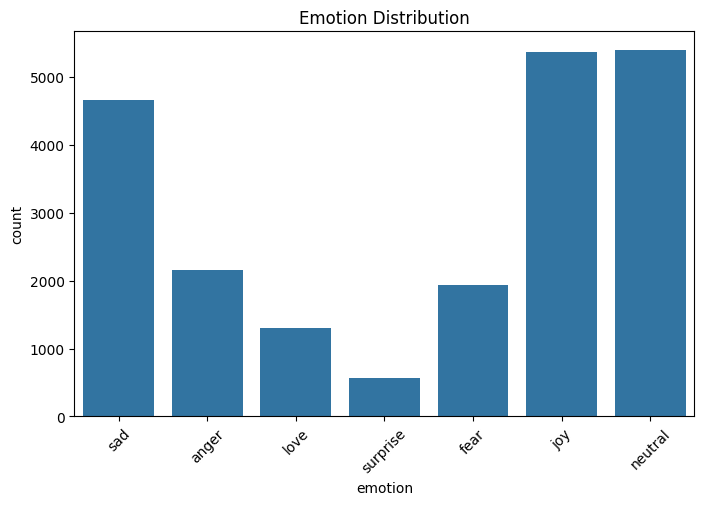

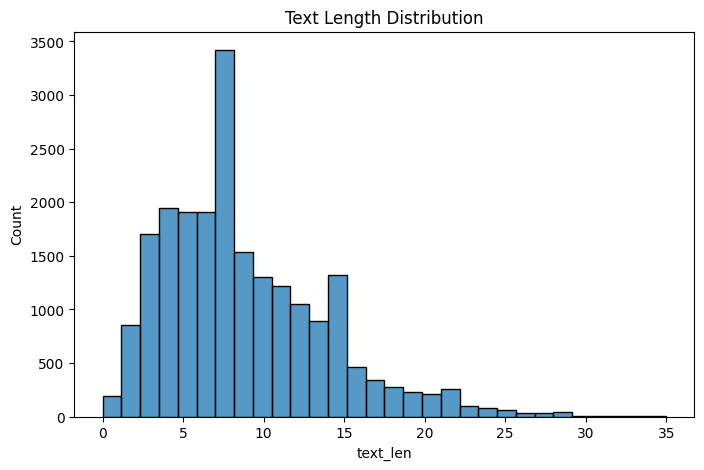

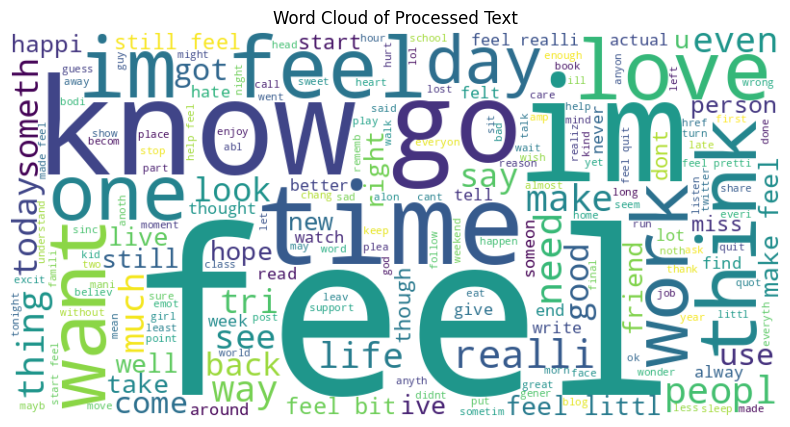

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', data=df1)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

# Text length distribution
df1['text_len'] = df1['processed_text_class'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df1['text_len'], bins=30)
plt.title("Text Length Distribution")
plt.show()

# Word Cloud
text_combined = " ".join(df1['processed_text_class'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Text")
plt.show()


In [28]:
# -----------------------------------
# Label Encoding (shared for both)
# -----------------------------------
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['label'] = le.fit_transform(df1['emotion'])

# -----------------------------------
# Classical ML: TF-IDF + Train/Test/Val Split
# -----------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df1['processed_text_class'])  # Assume this column exists
y_classical = df1['label']

X_train_val, X_test_classical, y_train_val, y_test_classical = train_test_split(
    X_tfidf, y_classical, test_size=0.2, random_state=42, stratify=y_classical)

X_train_classical, X_val_classical, y_train_classical, y_val_classical = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# -----------------------------------
# Deep Learning: Tokenizer + Padding + One-hot Labels + Train/Test/Val Split
# -----------------------------------
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df1['text'])
sequences = tokenizer.texts_to_sequences(df1['text'])

max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
y_dl = to_categorical(df1['label'], num_classes=len(le.classes_))

# Split: 80% train+val, 20% test
X_train_val_dl, X_test_dl, y_train_val_dl, y_test_dl = train_test_split(
    padded_sequences, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Split: 80% of train_val → train, 20% → val → (64% train, 16% val)
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_val_dl, y_train_val_dl, test_size=0.2, random_state=42, stratify=y_train_val_dl)

# -----------------------------
# Final shapes check (optional)
# -----------------------------
print("TF-IDF - Train:", X_train_classical.shape)
print("TF-IDF - Val:", X_val_classical.shape)
print("TF-IDF - Test:", X_test_classical.shape)

print("DL - Train:", X_train_dl.shape)
print("DL - Val:", X_val_dl.shape)
print("DL - Test:", X_test_dl.shape)


TF-IDF - Train: (13696, 5000)
TF-IDF - Val: (3424, 5000)
TF-IDF - Test: (4280, 5000)
DL - Train: (13696, 66)
DL - Val: (3424, 66)
DL - Test: (4280, 66)


## ML Models


Training Naive Bayes...

Model: Naive Bayes (Best Params: {'alpha': 0.1}):
  Train Accuracy = 0.9035
  Val Accuracy   = 0.7377
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.80      0.61      0.69       345
        fear       0.83      0.59      0.69       310
         joy       0.65      0.88      0.75       858
        love       0.75      0.35      0.48       209
     neutral       0.86      0.77      0.81       864
         sad       0.71      0.84      0.77       747
    surprise       0.87      0.14      0.25        91

    accuracy                           0.74      3424
   macro avg       0.78      0.60      0.63      3424
weighted avg       0.76      0.74      0.73      3424



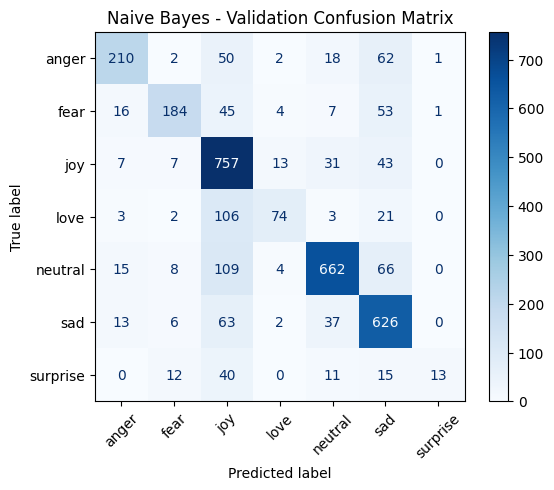


Training Logistic Regression...

Model: Logistic Regression (Best Params: {'C': 10}):
  Train Accuracy = 0.9872
  Val Accuracy   = 0.8645
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.84      0.81      0.82       345
        fear       0.86      0.79      0.82       310
         joy       0.82      0.90      0.86       858
        love       0.72      0.59      0.65       209
     neutral       0.94      0.96      0.95       864
         sad       0.88      0.89      0.89       747
    surprise       0.80      0.53      0.64        91

    accuracy                           0.86      3424
   macro avg       0.84      0.78      0.80      3424
weighted avg       0.86      0.86      0.86      3424



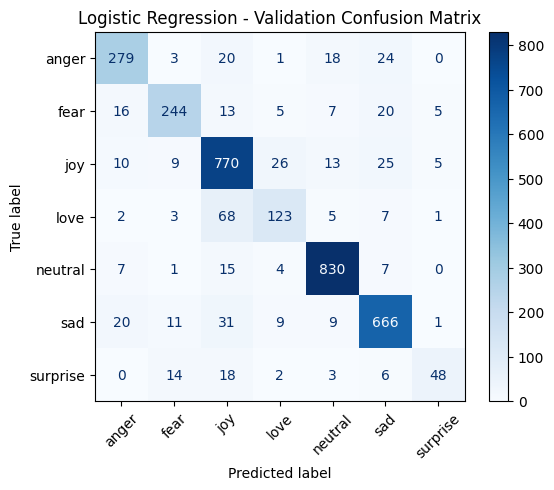


Training Gradient Boosting...

Model: Gradient Boosting (Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_iter_no_change': 5, 'validation_fraction': 0.1}):
  Train Accuracy = 0.8843
  Val Accuracy   = 0.8353
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.85      0.73      0.78       345
        fear       0.87      0.73      0.79       310
         joy       0.70      0.90      0.79       858
        love       0.78      0.58      0.67       209
     neutral       0.96      0.98      0.97       864
         sad       0.94      0.75      0.83       747
    surprise       0.67      0.85      0.75        91

    accuracy                           0.84      3424
   macro avg       0.82      0.79      0.80      3424
weighted avg       0.85      0.84      0.84      3424



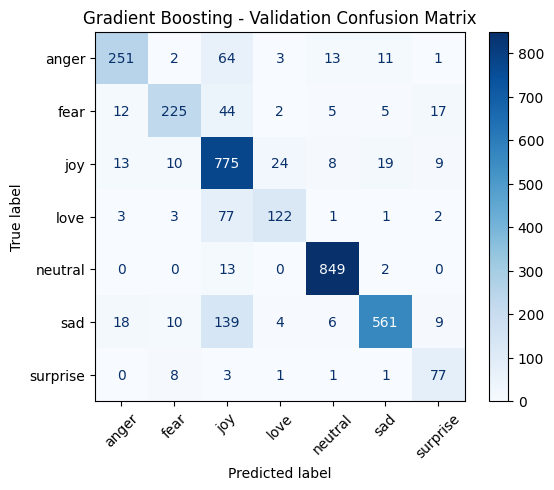


Training Linear SVM...

Model: Linear SVM (Best Params: {'C': 1}):
  Train Accuracy = 0.9765
  Val Accuracy   = 0.8732
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.84      0.85      0.84       345
        fear       0.84      0.79      0.81       310
         joy       0.85      0.89      0.87       858
        love       0.76      0.62      0.68       209
     neutral       0.94      0.97      0.95       864
         sad       0.89      0.90      0.89       747
    surprise       0.75      0.59      0.66        91

    accuracy                           0.87      3424
   macro avg       0.84      0.80      0.82      3424
weighted avg       0.87      0.87      0.87      3424



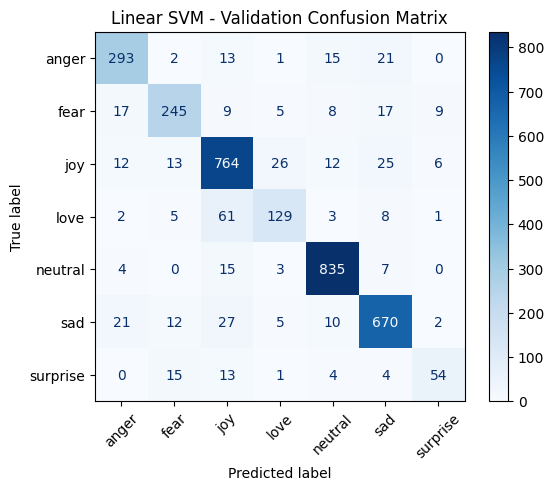


Training K-Nearest Neighbors...

Model: K-Nearest Neighbors (Best Params: {'n_neighbors': 3}):
  Train Accuracy = 0.4746
  Val Accuracy   = 0.3867
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.69      0.22      0.33       345
        fear       0.72      0.17      0.28       310
         joy       0.85      0.20      0.32       858
        love       0.75      0.14      0.24       209
     neutral       0.29      0.95      0.45       864
         sad       0.90      0.23      0.37       747
    surprise       0.50      0.03      0.06        91

    accuracy                           0.39      3424
   macro avg       0.67      0.28      0.29      3424
weighted avg       0.68      0.39      0.35      3424



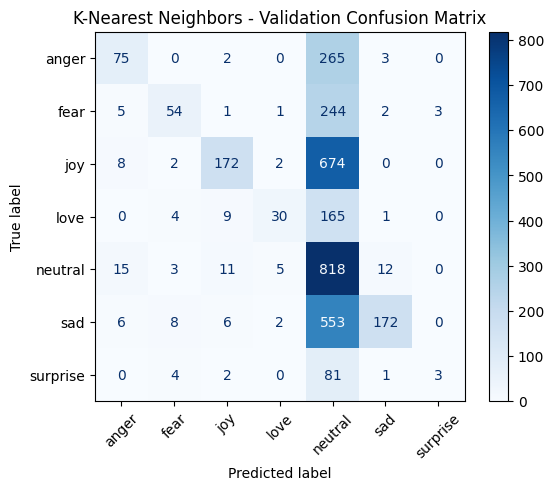


Training Decision Tree...

Model: Decision Tree (Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}):
  Train Accuracy = 0.9990
  Val Accuracy   = 0.8283
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.72      0.81      0.76       345
        fear       0.75      0.77      0.76       310
         joy       0.82      0.79      0.81       858
        love       0.62      0.64      0.63       209
     neutral       0.97      0.96      0.97       864
         sad       0.84      0.82      0.83       747
    surprise       0.65      0.66      0.65        91

    accuracy                           0.83      3424
   macro avg       0.77      0.78      0.77      3424
weighted avg       0.83      0.83      0.83      3424



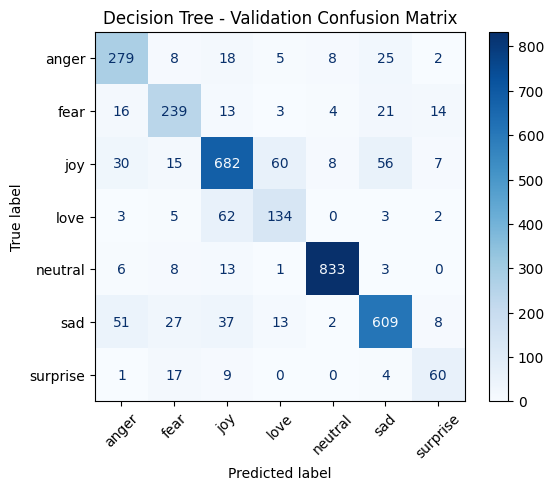


Training MLP Classifier...

Model: MLP Classifier (Best Params: {'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (128,), 'validation_fraction': 0.1}):
  Train Accuracy = 0.9485
  Val Accuracy   = 0.8306
  Classification Report (Validation):
               precision    recall  f1-score   support

       anger       0.83      0.78      0.80       345
        fear       0.85      0.76      0.80       310
         joy       0.79      0.87      0.83       858
        love       0.73      0.61      0.66       209
     neutral       0.87      0.91      0.89       864
         sad       0.85      0.86      0.85       747
    surprise       0.88      0.38      0.53        91

    accuracy                           0.83      3424
   macro avg       0.83      0.74      0.77      3424
weighted avg       0.83      0.83      0.83      3424



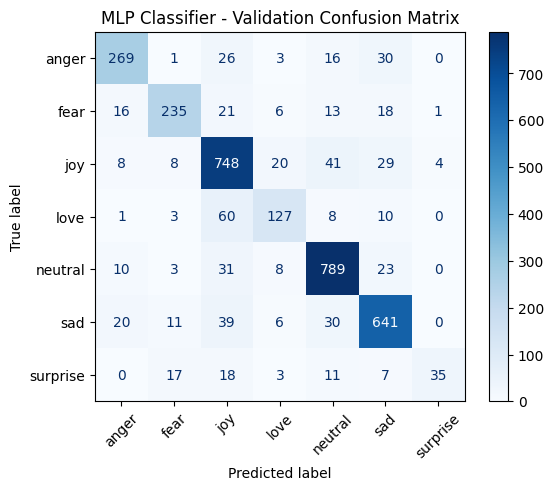

<ipython-input-29-af14cf680442>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_vals), y=list(model_names), palette="mako")


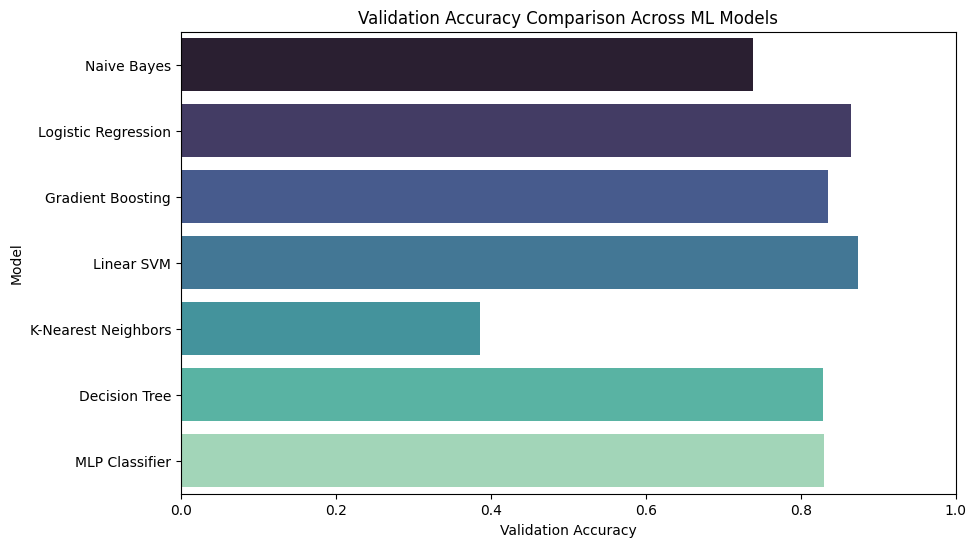


Evaluating the Best Model (Linear SVM) on the Test Set:
  Test Accuracy = 0.8745
  Classification Report (Test):
               precision    recall  f1-score   support

       anger       0.83      0.82      0.82       432
        fear       0.87      0.84      0.85       387
         joy       0.85      0.88      0.87      1072
        love       0.78      0.61      0.68       261
     neutral       0.94      0.97      0.95      1080
         sad       0.88      0.90      0.89       933
    surprise       0.78      0.63      0.70       115

    accuracy                           0.87      4280
   macro avg       0.85      0.81      0.82      4280
weighted avg       0.87      0.87      0.87      4280



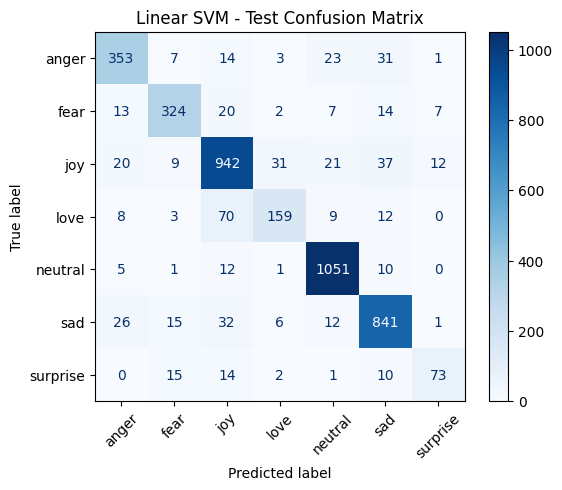

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter grids
param_grids = {
    "Naive Bayes": {
        "alpha": [0.1, 1.0, 10.0]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        "max_depth": [10, 15, 20, None],
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [100],
        "learning_rate": [0.1],
        "max_depth": [3],
        "n_iter_no_change": [5],
        "validation_fraction": [0.1]
    },
    "Linear SVM": {
        "C": [0.01, 0.1, 1]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7]
    },
    "MLP Classifier": {
        "hidden_layer_sizes": [(64,), (128,)],
        "alpha": [0.0001, 0.001],
        "early_stopping": [True],
        "validation_fraction": [0.1]
    }
}

# Base models
base_models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=300, random_state=42)
}

# Store best model details
best_model = None
best_val_accuracy = 0
best_model_name = ""

# Store for visualization
val_accuracies = []

# Train + evaluate
for name in base_models:
    print(f"\nTraining {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_train_classical, y_train_classical)

    current_model = grid.best_estimator_

    y_train_pred = current_model.predict(X_train_classical)
    y_val_pred = current_model.predict(X_val_classical)
    y_test_pred = current_model.predict(X_test_classical)

    val_accuracy = accuracy_score(y_val_classical, y_val_pred)
    val_accuracies.append((name, val_accuracy))

    print(f"\nModel: {name} (Best Params: {grid.best_params_}):")
    print(f"  Train Accuracy = {accuracy_score(y_train_classical, y_train_pred):.4f}")
    print(f"  Val Accuracy   = {val_accuracy:.4f}")
    print("  Classification Report (Validation):\n", classification_report(y_val_classical, y_val_pred, target_names=le.classes_))

    # Visual Confusion Matrix for Validation Set
    ConfusionMatrixDisplay.from_predictions(
        y_val_classical, y_val_pred, display_labels=le.classes_,
        cmap='Blues', xticks_rotation=45
    )
    plt.title(f"{name} - Validation Confusion Matrix")
    plt.grid(False)
    plt.show()

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = current_model
        best_model_name = name

# Compare Model Accuracies
model_names, accuracy_vals = zip(*val_accuracies)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_vals), y=list(model_names), palette="mako")
plt.xlabel("Validation Accuracy")
plt.ylabel("Model")
plt.title("Validation Accuracy Comparison Across ML Models")
plt.xlim(0, 1)
plt.show()

# Final Evaluation on Test Set
if best_model:
    print(f"\nEvaluating the Best Model ({best_model_name}) on the Test Set:")
    y_test_pred_best = best_model.predict(X_test_classical)
    test_accuracy_best = accuracy_score(y_test_classical, y_test_pred_best)
    print(f"  Test Accuracy = {test_accuracy_best:.4f}")
    print("  Classification Report (Test):\n", classification_report(y_test_classical, y_test_pred_best, target_names=le.classes_))

    #Final Confusion Matrix for Test Set
    ConfusionMatrixDisplay.from_predictions(
        y_test_classical, y_test_pred_best, display_labels=le.classes_,
        cmap='Blues', xticks_rotation=45
    )
    plt.title(f"{best_model_name} - Test Confusion Matrix")
    plt.grid(False)
    plt.show()


In [30]:
custom_text = "I'm really confused and feel lost right now."

# Preprocess using your TextProcessor class (stem, stopword removal, lowercase)
processed_custom_text = processor.transform([custom_text])

# Convert processed text to TF-IDF vector (using your fitted TF-IDF vectorizer)
custom_tfidf = tfidf.transform(processed_custom_text)

# Predict emotion
predicted_label_idx = best_model.predict(custom_tfidf)

# Decode label back to original emotion label
predicted_emotion = le.inverse_transform(predicted_label_idx)

print("Predicted Emotion:", predicted_emotion[0])


Predicted Emotion: fear


# Deep Learning Models for Emotion Detection

In [31]:
# Data preparation (continued from previous steps)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, concatenate, Multiply, Activation, Lambda

# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df1['text'])
sequences = tokenizer.texts_to_sequences(df1['text'])

max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
# Define num_classes here
num_classes = len(le.classes_)
y_dl = to_categorical(df1['label'], num_classes=num_classes)


# Split: 80% train+val, 20% test
X_train_val_dl, X_test_dl, y_train_val_dl, y_test_dl = train_test_split(
    padded_sequences, y_dl, test_size=0.2, random_state=42, stratify=y_dl)

# Split: 80% of train_val → train, 20% → val → (64% train, 16% val)
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_val_dl, y_train_val_dl, test_size=0.2, random_state=42, stratify=y_train_val_dl)


print("DL - Train:", X_train_dl.shape)
print("DL - Val:", X_val_dl.shape)
print("DL - Test:", X_test_dl.shape)


DL - Train: (13696, 66)
DL - Val: (3424, 66)
DL - Test: (4280, 66)


In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Multiply, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# ========== Model Builder Functions ==========
def build_model(name, vocab_size, max_len, num_classes):
    input_layer = Input(shape=(max_len,))
    x = Embedding(vocab_size, 128, input_length=max_len)(input_layer)

    if name == "LSTM":
        x = LSTM(64)(x)
    elif name == "BiLSTM":
        x = Bidirectional(LSTM(64))(x)
    elif name == "GRU":
        x = GRU(128)(x)
    elif name == "BiGRU":
        x = Bidirectional(GRU(64))(x)
    elif name == "1D_CNN":
        x = Conv1D(128, kernel_size=5, activation='relu')(x)
        x = GlobalMaxPooling1D()(x)
    elif name == "CNN_BiLSTM":
        x = Conv1D(64, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Bidirectional(LSTM(64))(x)
    elif name == "CNN_Attention":
        filter_sizes = [3, 4, 5]
        conv_outputs = []
        for filter_size in filter_sizes:
            conv = Conv1D(128, filter_size, activation='relu')(x)
            pool = GlobalMaxPooling1D()(conv)
            conv_outputs.append(pool)
        merged = concatenate(conv_outputs)
        attention_probs = Dense(merged.shape[-1], activation='softmax')(merged)
        x = Multiply()([merged, attention_probs])
    else:
        raise ValueError("Unknown model name")

    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [33]:
# ========== Training & Plotting Function ==========
def train_and_plot(model, X_train, y_train, X_val, y_val, name, epochs=5, batch_size=64):
    print(f"\nTraining {name}...")
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Training Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training LSTM...
Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2393 - loss: 1.7838 - val_accuracy: 0.2523 - val_loss: 1.7513
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2475 - loss: 1.7586 - val_accuracy: 0.2582 - val_loss: 1.7426
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2495 - loss: 1.7533 - val_accuracy: 0.2535 - val_loss: 1.7434
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2548 - loss: 1.7502 - val_accuracy: 0.2494 - val_loss: 1.7425
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2508 - loss: 1.7459 - val_accuracy: 0.2523 - val_loss: 1.7428


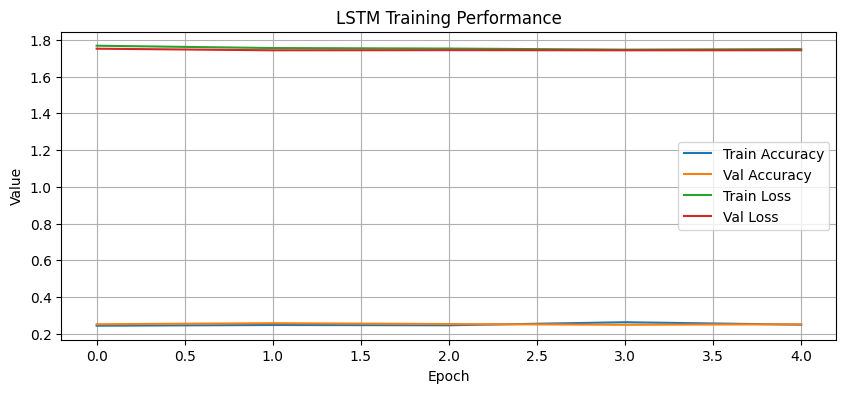

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

LSTM Accuracy: 0.2494
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
        fear       0.00      0.00      0.00       310
         joy       0.25      1.00      0.40       858
        love       0.00      0.00      0.00       209
     neutral       0.00      0.00      0.00       864
         sad       0.00      0.00      0.00       747
    surprise       0.00      0.00      0.00        91

    accuracy                           0.25      3424
   macro avg       0.04      0.14      0.06      3424
weighted avg       0.06      0.25      0.10      3424

Confusion Matrix:
[[  0   0 344   0   1   0   0]
 [  0   0 310   0   0   0   0]
 [  0   0 854   0   4   0   0]
 [  0   0 209   0   0   0   0]
 [  0   0 864   0   0   0   0]
 [  0   0 743   0   4   0   0]
 [  0   0  91   0   0   0   0]]

Training BiLSTM...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3884 - loss: 1.5470 - val_accuracy: 0.6317 - val_loss: 1.1042
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6959 - loss: 0.8961 - val_accuracy: 0.8312 - val_loss: 0.5406
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8930 - loss: 0.3561 - val_accuracy: 0.8925 - val_loss: 0.3345
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9555 - loss: 0.1598 - val_accuracy: 0.9042 - val_loss: 0.2987
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9757 - loss: 0.0891 - val_accuracy: 0.9057 - val_loss: 0.3219


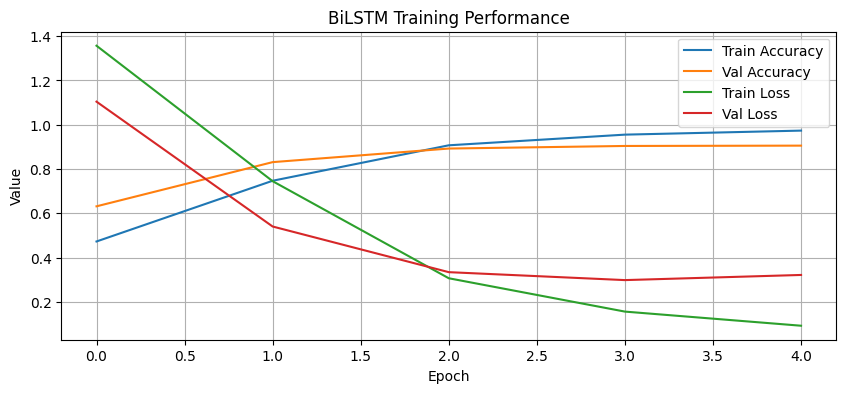

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

BiLSTM Accuracy: 0.9042
Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.90      0.86       345
        fear       0.83      0.84      0.83       310
         joy       0.93      0.89      0.91       858
        love       0.71      0.86      0.78       209
     neutral       0.97      0.98      0.98       864
         sad       0.95      0.91      0.93       747
    surprise       0.70      0.55      0.62        91

    accuracy                           0.90      3424
   macro avg       0.85      0.85      0.84      3424
weighted avg       0.91      0.90      0.90      3424

Confusion Matrix:
[[310   2   7   4   9  13   0]
 [ 18 260   6   1   3   7  15]
 [ 11   3 762  60   8  12   2]
 [  5   1  17 180   0   4   2]
 [  4   0   5   1 851   1   2]
 [ 24  16  17   5   2 683   0]
 [  3  31   2   4   1   0  50]]

Training GRU...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2491 - loss: 1.7736 - val_accuracy: 0.2523 - val_loss: 1.7487
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2553 - loss: 1.7505 - val_accuracy: 0.4623 - val_loss: 1.6633
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4848 - loss: 1.3511 - val_accuracy: 0.6054 - val_loss: 1.1524
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6889 - loss: 0.9158 - val_accuracy: 0.7553 - val_loss: 0.6540
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8382 - loss: 0.4714 - val_accuracy: 0.8805 - val_loss: 0.3998


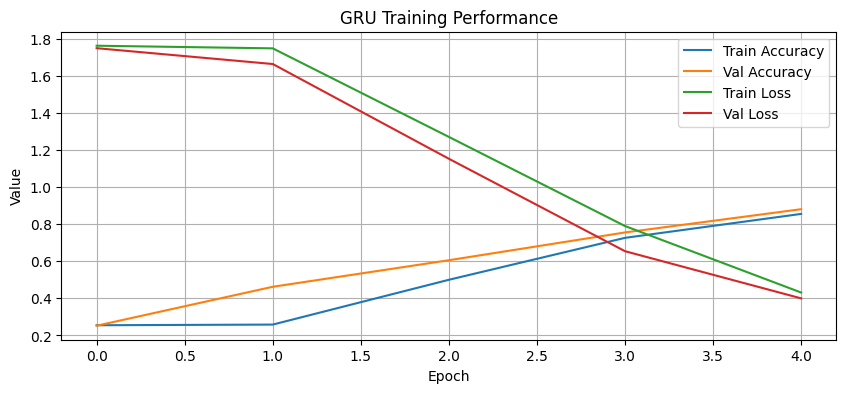

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

GRU Accuracy: 0.8805
Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.77      0.74       345
        fear       0.72      0.85      0.78       310
         joy       0.93      0.92      0.93       858
        love       0.59      0.71      0.65       209
     neutral       0.98      0.97      0.98       864
         sad       0.97      0.94      0.96       747
    surprise       0.00      0.00      0.00        91

    accuracy                           0.88      3424
   macro avg       0.70      0.74      0.72      3424
weighted avg       0.87      0.88      0.87      3424

Confusion Matrix:
[[267  22   3  38   6   9   0]
 [ 29 264   3   4   3   7   0]
 [ 14   4 791  44   4   1   0]
 [  8   6  43 148   1   3   0]
 [  8   4   3   5 842   2   0]
 [ 10  28   3   3   0 703   0]
 [ 45  38   1   7   0   0   0]]

Training BiGRU...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3922 - loss: 1.5536 - val_accuracy: 0.5225 - val_loss: 1.2051
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5963 - loss: 1.0990 - val_accuracy: 0.7886 - val_loss: 0.6619
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8320 - loss: 0.5232 - val_accuracy: 0.8633 - val_loss: 0.4380
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9133 - loss: 0.2828 - val_accuracy: 0.8744 - val_loss: 0.3764
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9485 - loss: 0.1684 - val_accuracy: 0.8984 - val_loss: 0.3406


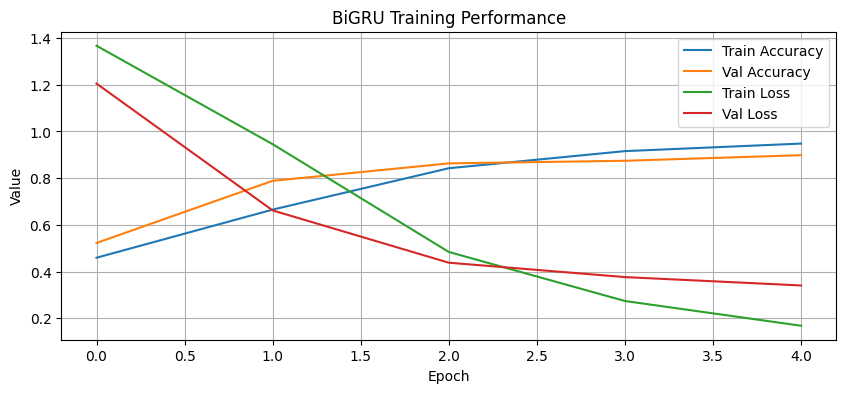

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

BiGRU Accuracy: 0.8984
Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.83      0.83       345
        fear       0.82      0.87      0.84       310
         joy       0.94      0.90      0.92       858
        love       0.71      0.80      0.75       209
     neutral       0.99      0.94      0.97       864
         sad       0.90      0.95      0.93       747
    surprise       0.67      0.58      0.62        91

    accuracy                           0.90      3424
   macro avg       0.84      0.84      0.84      3424
weighted avg       0.90      0.90      0.90      3424

Confusion Matrix:
[[285   3   6   5   7  31   8]
 [  7 270   1   3   1  14  14]
 [ 13   2 771  54   3  14   1]
 [  3   5  25 168   0   7   1]
 [ 23   4   9   1 816   9   2]
 [  9  17   5   3   0 713   0]
 [  2  29   3   4   0   0  53]]

Training 1D_CNN...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3860 - loss: 1.6072 - val_accuracy: 0.7839 - val_loss: 0.7866
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8275 - loss: 0.5898 - val_accuracy: 0.9276 - val_loss: 0.2357
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9323 - loss: 0.2229 - val_accuracy: 0.9325 - val_loss: 0.1848
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9491 - loss: 0.1481 - val_accuracy: 0.9346 - val_loss: 0.1748
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9665 - loss: 0.1043 - val_accuracy: 0.9317 - val_loss: 0.1888


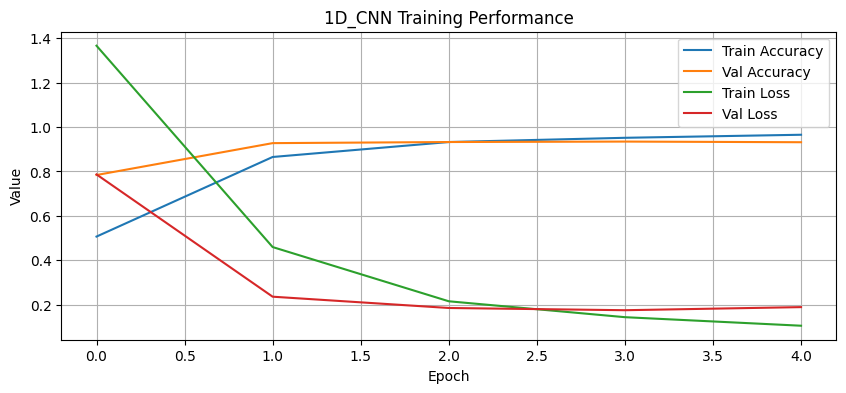

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

1D_CNN Accuracy: 0.9346
Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       345
        fear       0.86      0.88      0.87       310
         joy       0.93      0.95      0.94       858
        love       0.82      0.84      0.83       209
     neutral       0.98      0.97      0.98       864
         sad       0.96      0.96      0.96       747
    surprise       0.85      0.66      0.74        91

    accuracy                           0.93      3424
   macro avg       0.90      0.88      0.89      3424
weighted avg       0.93      0.93      0.93      3424

Confusion Matrix:
[[322   3   1   1   7  11   0]
 [ 15 274   2   0   4   7   8]
 [  1   0 815  30   7   4   1]
 [  0   2  29 175   0   3   0]
 [  0   3  14   3 839   5   0]
 [  7  11   7   5   0 715   2]
 [  1  25   5   0   0   0  60]]

Training CNN_BiLSTM...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3731 - loss: 1.5702 - val_accuracy: 0.6694 - val_loss: 0.9787
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7369 - loss: 0.7766 - val_accuracy: 0.8677 - val_loss: 0.4212
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9126 - loss: 0.2715 - val_accuracy: 0.8838 - val_loss: 0.3636
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9606 - loss: 0.1400 - val_accuracy: 0.9019 - val_loss: 0.3424
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9772 - loss: 0.0833 - val_accuracy: 0.9065 - val_loss: 0.3300


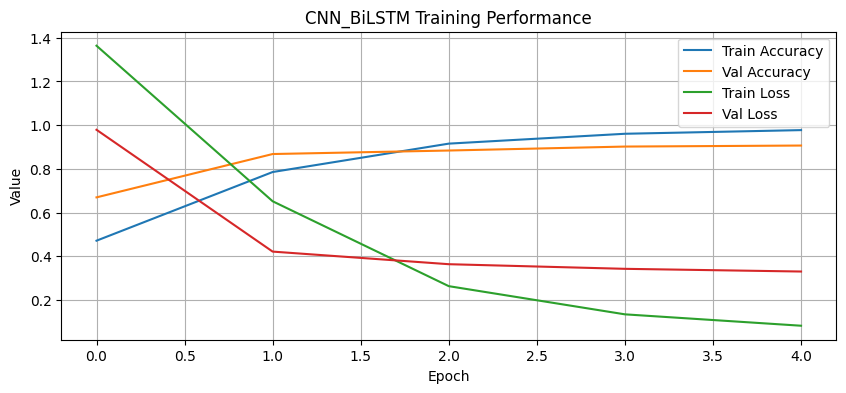

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

CNN_BiLSTM Accuracy: 0.9065
Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.84      0.86       345
        fear       0.84      0.87      0.86       310
         joy       0.91      0.92      0.91       858
        love       0.76      0.80      0.78       209
     neutral       0.96      0.98      0.97       864
         sad       0.94      0.92      0.93       747
    surprise       0.73      0.56      0.63        91

    accuracy                           0.91      3424
   macro avg       0.86      0.84      0.85      3424
weighted avg       0.91      0.91      0.91      3424

Confusion Matrix:
[[291   5  14   2  20  12   1]
 [ 12 271   3   0   3  10  11]
 [  5   1 788  44   7  12   1]
 [  3   1  29 167   0   4   5]
 [  3   1   8   0 847   4   1]
 [ 14  13  25   3   3 689   0]
 [  4  29   2   5   0   0  51]]

Training CNN_Attention...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3004 - loss: 1.7939 - val_accuracy: 0.4956 - val_loss: 1.2967
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4489 - loss: 1.4602 - val_accuracy: 0.4953 - val_loss: 1.2580
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4741 - loss: 1.3514 - val_accuracy: 0.4936 - val_loss: 1.2492
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4873 - loss: 1.3197 - val_accuracy: 0.4968 - val_loss: 1.2522
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4838 - loss: 1.3020 - val_accuracy: 0.4968 - val_loss: 1.0798


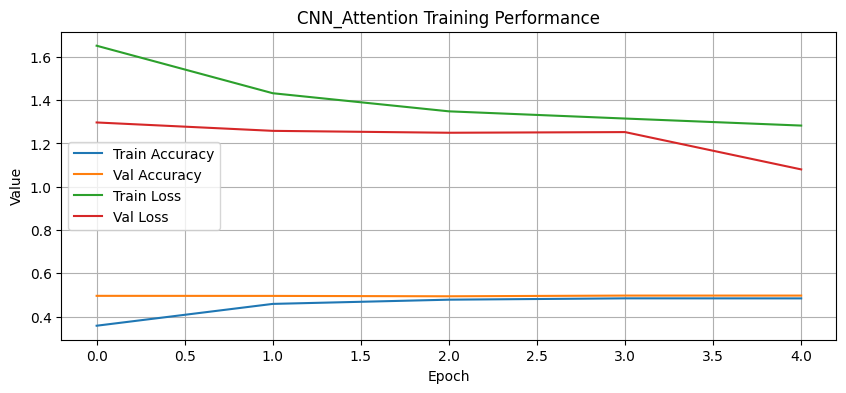

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN_Attention Accuracy: 0.4968
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
        fear       0.00      0.00      0.00       310
         joy       0.43      0.95      0.60       858
        love       0.00      0.00      0.00       209
     neutral       0.98      0.97      0.98       864
         sad       0.07      0.06      0.06       747
    surprise       0.00      0.00      0.00        91

    accuracy                           0.50      3424
   macro avg       0.21      0.28      0.23      3424
weighted avg       0.37      0.50      0.41      3424

Confusion Matrix:
[[  0   0 118   0   6 221   0]
 [  0   0  66   0   4 240   0]
 [  0   0 814   0   5  39   0]
 [  0   0 123   0   0  86   0]
 [  0   0  23   0 841   0   0]
 [  0   0 701   0   0  46   0]
 [  0   0  28   0   0  63   0]]

Best Model: 1D_CNN with Accuracy = 0.9346


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# ========== Model Names ==========
model_names = ["LSTM", "BiLSTM", "GRU", "BiGRU", "1D_CNN", "CNN_BiLSTM", "CNN_Attention"]

# ========== Training All Models ==========
models = {}
accuracies = {}

for name in model_names:
    model = build_model(name, vocab_size, max_len, num_classes)
    model = train_and_plot(model, X_train_dl, y_train_dl, X_val_dl, y_val_dl, name)

    loss, acc = model.evaluate(X_val_dl, y_val_dl, verbose=0)
    accuracies[name] = acc
    models[name] = model

    y_pred = np.argmax(model.predict(X_val_dl), axis=1)
    y_true = np.argmax(y_val_dl, axis=1)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# ========== Best Model ==========
best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest Model: {best_model_name} with Accuracy = {accuracies[best_model_name]:.4f}")

In [38]:
# ========== Predict on Custom Sentence ==========

# Custom sentence
custom_text = "I can't stop smiling today, everything feels perfect!"

# Tokenization + Padding (نفس الخطوات اللي استخدمتها في التدريب)
custom_seq = tokenizer.texts_to_sequences([custom_text])
custom_pad = pad_sequences(custom_seq, maxlen=max_len, padding='post')

# Use the best model for prediction
best_model = models[best_model_name]  # Get best performing model from dictionary
prediction = best_model.predict(custom_pad)
predicted_idx = np.argmax(prediction, axis=1)
predicted_emotion = le.inverse_transform(predicted_idx)

print(f"\n🎯 Predicted Emotion: {predicted_emotion[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step

🎯 Predicted Emotion: joy
